# NBA Position Prediction Project

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
df = pd.read_csv("NBA.csv", sep=";")

## 1. Data Cleaning
Handling traded players (removing duplicates) and standardizing position labels.

In [18]:
#cleaned data for analysis by removing duplicate(traded) players
tot_players = df[df["Tm"] == "TOT"]["Player"]
tot = df[df['Tm'] == 'TOT'].copy()
single_team = df[~df['Player'].isin(tot_players)].copy()
cleaned_df = pd.concat([tot,single_team], ignore_index=True)


In [19]:
#Standardize player position, gives each player only 1 position.
cleaned_df['Pos'] = cleaned_df['Pos'].apply(lambda x: x.split('-')[0])

## 2. Baseline Model
Running the Random Forest classifier on raw statistics without any feature engineering.

Accuracy: 0.41739130434782606
 
Report:                precision    recall  f1-score   support

           C       0.65      0.79      0.71        19
          PF       0.29      0.23      0.26        22
          PG       0.61      0.50      0.55        22
          SF       0.37      0.28      0.32        25
          SG       0.26      0.37      0.31        27

    accuracy                           0.42       115
   macro avg       0.44      0.43      0.43       115
weighted avg       0.42      0.42      0.41       115



Text(0.5, 1.0, 'Model 1 Confusion Matrix')

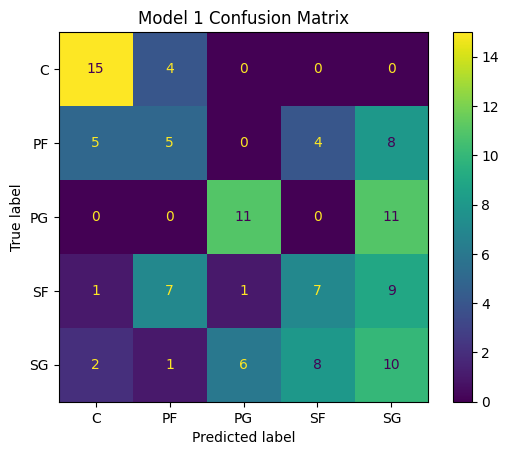

In [20]:
#generate training/testing splits, initialize, fit, predict, and return the accurary and classification report from random forest classifier
Y = cleaned_df['Pos']
X = cleaned_df.drop(columns=["Rk", "Player", "Tm", "Pos"])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
model = RandomForestClassifier(random_state= 42)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)
accuracy = accuracy_score(Y_test, predictions)
report = classification_report(Y_test, predictions)

print("Accuracy:", accuracy)
print(" ")
print("Report: ",  report)
modelmatrix1 = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test)
plt.title("Model 1 Confusion Matrix")

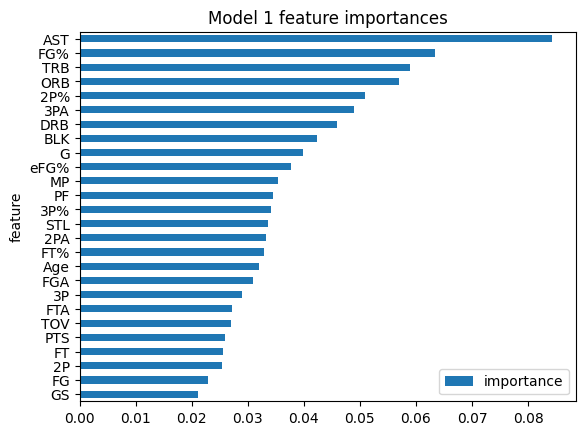

In [21]:
#analyzing feature selection to increase accuracy.
importances = model.feature_importances_
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importances}).sort_values(by='importance', ascending=True)
feature_importance.plot(kind='barh', x="feature", y="importance", title="Model 1 feature importances")
plt.show()

## 3. Feature Engineering: Assist-to-Turnover Ratio
Creating an efficiency metric to better distinguish Point Guards from other ball handlers.

In [22]:
#feature engineering with AST/TOV stat to more clearly identify PGs
cleaned_df2 = cleaned_df.copy()
cleaned_df2["AST/TOV"]  = (cleaned_df2["AST"]/cleaned_df2["TOV"])
cleaned_df2['AST/TOV'] = cleaned_df2['AST/TOV'].fillna(0)
cleaned_df2['AST/TOV'] = cleaned_df2['AST/TOV'].replace(np.inf, 0)

In [23]:
#creating new training and testing data with new feature
Y2 = cleaned_df2["Pos"]
X2 = cleaned_df2.drop(columns=["Rk", "Player", "Tm", "Pos"])

### Model 2 Results
Accuracy improved slightly (~45%). The confusion matrix shows the model still confuses SG (Shooting Guards) with SF (Small Forwards).

Accuracy:  0.44755244755244755
 
Report:                precision    recall  f1-score   support

           C       0.58      0.75      0.65        24
          PF       0.44      0.29      0.35        28
          PG       0.54      0.48      0.51        27
          SF       0.41      0.23      0.29        31
          SG       0.34      0.55      0.42        33

    accuracy                           0.45       143
   macro avg       0.46      0.46      0.44       143
weighted avg       0.45      0.45      0.43       143



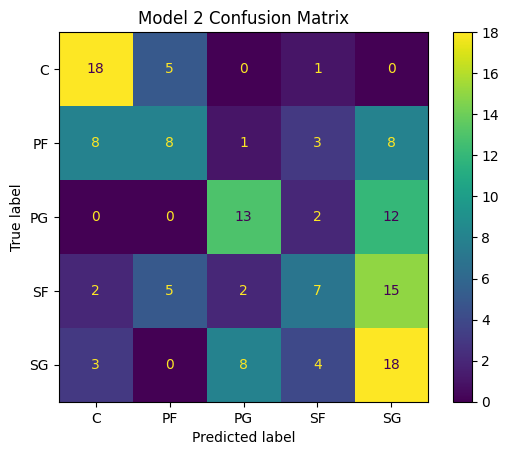

In [24]:
#generating new testing/training splits with new feature
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2,Y2, random_state=42, stratify=Y2)
model2 = RandomForestClassifier(random_state=42)
model2.fit(X2_train,Y2_train)
prediction2 = model2.predict(X2_test)
accuracy2 = accuracy_score(Y2_test,prediction2)
report2 = classification_report(Y2_test, prediction2)

print("Accuracy: ", accuracy2)
print(" ")
print("Report: ",  report2)

modelmatrix2 = ConfusionMatrixDisplay.from_estimator(model2,X2_test,Y2_test)
plt.title("Model 2 Confusion Matrix")
plt.show()

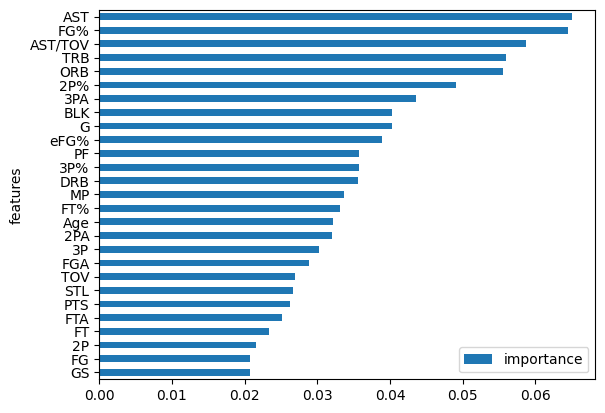

In [25]:
importances2 = model2.feature_importances_
feature_importance2 = pd.DataFrame({"features": X2.columns, "importance":importances2}).sort_values(by="importance", ascending=True)
feature_importance2.plot(kind="barh", x = "features", y = "importance")
plt.show()

## 5. Feature Engineering: Perimeter vs. Interior
Creating a "3-Point Attempts per Rebound" ratio. This metric aims to separate "Wing" players (High 3PA) from "Bigs" (High TRB).

In [26]:
#Feature engineering for model 3
cleaned_df3 = cleaned_df2.copy()
cleaned_df3["3PA/TRB"] = (cleaned_df3["3PA"]/cleaned_df3['TRB'])

cleaned_df3["3PA/TRB"] = cleaned_df3["3PA/TRB"].fillna(0)
cleaned_df3["3PA/TRB"] = cleaned_df3["3PA/TRB"].replace(np.inf, 0)

In [27]:
#Training and testing data
Y3 = cleaned_df3['Pos']
X3 = cleaned_df3.drop(columns=["Rk", "Player", "Tm", "Pos"])

In [28]:
#Create training/testing splits
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y3, random_state=42, stratify=Y3)

### Model 3 Results
Accuracy dipped slightly. The confusion matrix shows the model did not benefit from new feature. This new feature acted more as noise resulting in a lower accuracy. 

model 3 accuracy: 0.4405594405594406

Report:
               precision    recall  f1-score   support

           C       0.56      0.75      0.64        24
          PF       0.31      0.18      0.23        28
          PG       0.60      0.44      0.51        27
          SF       0.43      0.32      0.37        31
          SG       0.35      0.55      0.42        33

    accuracy                           0.44       143
   macro avg       0.45      0.45      0.43       143
weighted avg       0.44      0.44      0.43       143



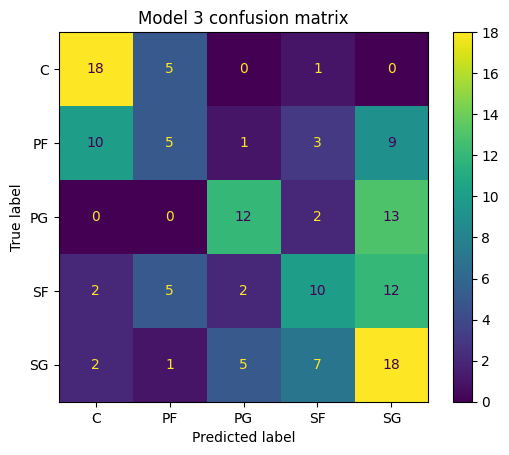

In [29]:
#initialize, fit, predict, and display results. 
model3 = RandomForestClassifier(random_state=42)
model3.fit(X3_train, Y3_train)
prediction3 = model3.predict(X3_test)
accuracy3 = accuracy_score(Y3_test, prediction3)
report3 = classification_report(Y3_test, prediction3)
modelmatrix3 = ConfusionMatrixDisplay.from_estimator(model3, X3_test, Y3_test)
print("model 3 accuracy:", accuracy3)
print("\nReport:\n", report3)
plt.title("Model 3 confusion matrix")
plt.show()

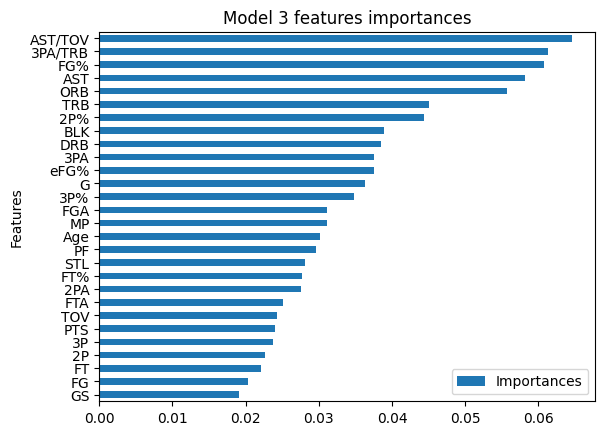

In [30]:
#analyzing features

importances3 = model3.feature_importances_
feature_importance3 = pd.DataFrame({"Features": X3.columns, "Importances": importances3}).sort_values(by="Importances", ascending=True)
feature_importance3.plot(kind="barh", x = "Features", y = "Importances", title="Model 3 features importances")
plt.show()

## Project Conclusion
The Random Forest model topped out at approximately 45% accuracy. 

**Key Insights:**
1. **The "Position-less" Era:** The model frequently confuses Shooting Guards and Small Forwards. This aligns with modern NBA analytics, where "Wing" players often share identical stats regardless of their assigned position.
2. **Feature Engineering:** Adding the Assist-to-Turnover ratio helped identify Point Guards more accurately, but physical stats (Rebounds/Blocks) remain the strongest indicators for Centers.
3. **The Power Forward Ambiguity:** The model struggled most with Power Forwards (lowest precision/recall scores). This suggests the "PF" position is currently the most versatile role in the NBA, blending statistical traits of both Centers and Wings, making it mathematically difficult to define.